# 1. Modules and functions

In [1]:
!pip install catboost

In [2]:
!pip install shap

In [3]:
# just to make it available to download w/o SSL verification
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import shap
import numpy as np
import pandas as pd
import datetime as dt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from lightfm.data import Dataset
from lightfm import LightFM

from catboost import CatBoostClassifier

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
LightFM was compiled without OpenMP support. Only a single thread will be used.


# 2. Main

## 2.1. Load Data

In [4]:
# interactions data
interactions = pd.read_csv(r'C:\Users\qwerty\RecSys SoA\baseline\interactions.csv', index_col = 0)
interactions.head()

,platform,utc_event_time,utc_event_date,user_id,event_type,price,quantity,item_id,id,timestamp_event_time,year,month,day,hour,lag_event_timestamp,is_first_event,timestamp_first_event,session_id,session_duration
417402,iOS,2023-07-31 17:24:27+00:00,2023-07-31,143590102216846121629039128341490394374,view_item,193900.000,1.000,156221170788598230427691940792446746137,2493,2023-07-31 20:24:27,2023,7,31,20,NaN,1,2023-07-31 20:24:27,2493,0
228061,Site,2023-07-31 17:19:59+00:00,2023-07-31,68356612019202583998435190963122559941,view_item,73900.000,1.000,91985325974930609197355477501114070594,25769804372,2023-07-31 20:19:59,2023,7,31,20,NaN,1,2023-07-31 20:19:59,25769804372,0
201110,iOS,2023-07-31 19:33:34+00:00,2023-07-31,233732236473179357801373437030185786199,view_item,325500.000,1.000,137171979943224305486022309005376289351,17179870242,2023-07-31 22:33:34,2023,7,31,22,2023-07-31 22:27:41,0,NaN,17179870241,353
228060,Site,2023-07-31 18:44:12+00:00,2023-07-31,68356612019202583998435190963122559941,add_to_cart,43800.000,1.000,100782420856388092094772448718057842500,8589942001,2023-07-31 21:44:12,2023,7,31,21,2023-07-31 20:19:59,1,2023-07-31 21:44:12,8589942001,0
281524,iOS,2023-07-31 21:14:49+00:00,2023-07-31,43931955929292411101534397335332520308,view_item,274200.000,1.000,55048021783355655476102933316512398170,17179874092,2023-08-01 00:14:49,2023,7,31,0,2023-07-31 20:15:42,1,2023-08-01 00:14:49,17179874092,83


In [5]:
# interactions.isna().sum()
interactions = interactions[interactions['price'].notna()]

## 2.2. Train/test split

## 2.3 Data preparation using LightFM Dataset (first-level model)

In [6]:
# set dates params for filter
MAX_DATE = pd.to_datetime(interactions['timestamp_event_time'].max())
MIN_DATE = pd.to_datetime(interactions['timestamp_event_time'].min())
TEST_INTERVAL_DAYS = 7

print(f"min date in filtered interactions: {MAX_DATE}")
print(f"max date in filtered interactions: {MIN_DATE}")

min date in filtered interactions: 2023-08-14 02:59:20
max date in filtered interactions: 2023-07-31 03:00:08


In [7]:
TEST_MAX_DATE = MAX_DATE - dt.timedelta(days = TEST_INTERVAL_DAYS)

In [8]:
# define global train and test
global_train = interactions.loc[pd.to_datetime(interactions['timestamp_event_time']) < TEST_MAX_DATE]
global_test = interactions.loc[pd.to_datetime(interactions['timestamp_event_time']) >= TEST_MAX_DATE]

print(global_train.shape, global_test.shape)

(232036, 19) (245251, 19)


In [9]:
# now, we define "local" train and test to use some part of the global train for ranker
local_train_thresh = pd.to_datetime(global_train['timestamp_event_time'].quantile(q = .7, interpolation = 'nearest'))
print(local_train_thresh)

2023-08-04 22:00:20


In [10]:
# global_train = global_train.dropna().reset_index(drop = True)

In [11]:
global_train.shape

(232036, 19)

In [12]:
local_train = global_train[pd.to_datetime(global_train['timestamp_event_time']) < local_train_thresh]
local_test = global_train[pd.to_datetime(global_train['timestamp_event_time']) >= local_train_thresh]

print(local_train.shape, local_test.shape)

(162424, 19) (69612, 19)


In [13]:
# finally, we will focus on warm start -- remove cold start users
local_test = local_test.loc[local_test['user_id'].isin(local_train['user_id'].unique())]
print(local_test.shape)

(42966, 19)


In [14]:
# init class
dataset = Dataset()

# fit tuple of user and movie interactions
dataset.fit(local_train['user_id'].unique(), local_train['item_id'].unique())

In [15]:
# now, we define lightfm mapper to use it later for checks
lightfm_mapping = dataset.mapping()
# lightfm_mapping

In [16]:
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'user_features_mapping': lightfm_mapping[1],
    'items_mapping': lightfm_mapping[2],
    'item_features_mapping': lightfm_mapping[3],
}
print('user mapper length - ', len(lightfm_mapping['users_mapping']))
print('user features mapper length - ', len(lightfm_mapping['user_features_mapping']))
print('movies mapper length - ', len(lightfm_mapping['items_mapping']))
print('Users movie features mapper length - ', len(lightfm_mapping['item_features_mapping']))

user mapper length -  70860
user features mapper length -  70860
movies mapper length -  143376
Users movie features mapper length -  143376


In [17]:
# here we create inverted mappers to check recommendations later
lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

In [18]:
# special iterator to use with lightfm
def df_to_tuple_iterator(df: pd.DataFrame):
    '''
    :df: pd.DataFrame, interactions dataframe
    returs iterator
    '''
    return zip(*df.values.T)

In [19]:
# defining train set on the whole interactions dataset (as HW you will have to split into test and train for evaluation)
train_mat, train_mat_weights = dataset.build_interactions(df_to_tuple_iterator(local_train[['user_id', 'item_id']]))

In [20]:
train_mat

<70860x143376 sparse matrix of type '<class 'numpy.int32'>'
	with 162424 stored elements in COOrdinate format>

In [21]:
train_mat_weights

<70860x143376 sparse matrix of type '<class 'numpy.float32'>'
	with 162424 stored elements in COOrdinate format>

## 2.4. Train LigthFM model

In [22]:
# set params
NO_COMPONENTS = 32
LEARNING_RATE = .25
# LOSS = 'warp'
MAX_SAMPLED = 5
RANDOM_STATE = 42
EPOCHS = 20
ITEM_ALPHA = 1e-6   # Regularization factor for item features
USER_ALPHA = 1e-6   # Regularization factor for user features

In [23]:
# init model
lfm_model = LightFM(
    no_components = NO_COMPONENTS,
    learning_rate = LEARNING_RATE,
#     loss = LOSS,
    max_sampled = MAX_SAMPLED,
    random_state = RANDOM_STATE,
    item_alpha=ITEM_ALPHA,
    user_alpha=USER_ALPHA
    )

In [24]:
# execute training
for _ in tqdm(range(EPOCHS), total = EPOCHS):
    lfm_model.fit_partial(
        train_mat,
        num_threads = 4
    )

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:07<00:00,  3.40s/it]


In [25]:
local_train['user_id']

417402    143590102216846121629039128341490394374
228061     68356612019202583998435190963122559941
201110    233732236473179357801373437030185786199
228060     68356612019202583998435190963122559941
281524     43931955929292411101534397335332520308
                           ...                   
197425    215585188727638612291023906692358377019
253782    204364795942286739646471282595160877018
337796    334179646638449945418121935797096623268
198059    219273247076088679226918057647416056877
358567    139838960850726607850472642551859344819
Name: user_id, Length: 162424, dtype: object

In [26]:
# let's make sense-check
top_N = 10
user_id = local_train['user_id'][358567]
row_id = lightfm_mapping['users_mapping'][user_id]
print(f'Rekko for user {user_id}, row number in matrix - {row_id}')

Rekko for user 139838960850726607850472642551859344819, row number in matrix - 6944


In [27]:
all_cols = list(lightfm_mapping['items_mapping'].values())
len(all_cols)

143376

In [28]:
pred = lfm_model.predict(
    row_id,
    all_cols,
    num_threads = 4)
pred, pred.shape

(array([2.8069394, 2.7331805, 2.4698913, ..., 2.807126 , 2.6174805,
        2.4702036], dtype=float32),
 (143376,))

In [29]:
top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
top_cols

array([ 1026,   607, 16522,  9254,  1605, 21419,   334,  1031,  2326,
        6449], dtype=int64)

In [30]:
recs = pd.DataFrame({'col_id': top_cols})
recs['item_id'] = recs['col_id'].map(lightfm_mapping['items_inv_mapping'].get)
# recs['title'] = recs['item_id'].map(item_name_mapper)
recs

,col_id,item_id
0,1026,236744202699948290060657693190981209002
1,607,237404600743079637226461910293775273824
2,16522,60426019840232385179488698169503208671
3,9254,95588577945262351643987306457854212185
4,1605,268867123658507796037972027312924025943
5,21419,101693639666891461420614362676113822951
6,334,211341525510156194317642392499306928053
7,1031,223630556631755871465874649022885940271
8,2326,278748058082175992864302242507744343524
9,6449,146034465447704226942031528185552793892


In [31]:
local_train['user_id']

417402    143590102216846121629039128341490394374
228061     68356612019202583998435190963122559941
201110    233732236473179357801373437030185786199
228060     68356612019202583998435190963122559941
281524     43931955929292411101534397335332520308
                           ...                   
197425    215585188727638612291023906692358377019
253782    204364795942286739646471282595160877018
337796    334179646638449945418121935797096623268
198059    219273247076088679226918057647416056877
358567    139838960850726607850472642551859344819
Name: user_id, Length: 162424, dtype: object

In [32]:
# let's make sense-check
top_N = 10
user_id = local_train['user_id'][337796]
row_id = lightfm_mapping['users_mapping'][user_id]
print(f'Rekko for user {user_id}, row number in matrix - {row_id}')

Rekko for user 334179646638449945418121935797096623268, row number in matrix - 26777


In [33]:
pred = lfm_model.predict(
    row_id,
    all_cols,
    num_threads = 4)
pred, pred.shape

(array([2.1341481, 2.0599144, 1.7997415, ..., 2.138835 , 1.951754 ,
        1.7957951], dtype=float32),
 (143376,))

In [34]:
top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
top_cols

array([ 1026,   607, 16522,  9254,  1605, 21419,   334,  1031,  2326,
       12771], dtype=int64)

In [35]:
recs = pd.DataFrame({'col_id': top_cols})
recs['item_id'] = recs['col_id'].map(lightfm_mapping['items_inv_mapping'].get)
# recs['title'] = recs['item_id'].map(item_name_mapper)
recs

,col_id,item_id
0,1026,236744202699948290060657693190981209002
1,607,237404600743079637226461910293775273824
2,16522,60426019840232385179488698169503208671
3,9254,95588577945262351643987306457854212185
4,1605,268867123658507796037972027312924025943
5,21419,101693639666891461420614362676113822951
6,334,211341525510156194317642392499306928053
7,1031,223630556631755871465874649022885940271
8,2326,278748058082175992864302242507744343524
9,12771,316369578318160560517812220790535630342


In [36]:
# let's make predictions for all users in test
test_preds = pd.DataFrame({
    'user_id': local_test['user_id'].unique()
})
# len(test_preds)

In [37]:
def generate_lightfm_recs_mapper(
        model: object,
        item_ids: list,
        known_items: dict,
        user_features: list,
        item_features: list,
        N: int,
        user_mapping: dict,
        item_inv_mapping: dict,
        num_threads: int = 4
        ):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.predict(
            user_id,
            item_ids,
            user_features = user_features,
            item_features = item_features,
            num_threads = num_threads)
        
        additional_N = len(known_items[user_id]) if user_id in known_items else 0
        total_N = N + additional_N
        top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]
        
        final_recs = [item_inv_mapping[item] for item in top_cols]
        if additional_N > 0:
            filter_items = known_items[user_id]
            final_recs = [item for item in final_recs if item not in filter_items]
        return final_recs[:N]
    return _recs_mapper

In [38]:
mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids = all_cols, 
    known_items = dict(),
    N = top_N,
    user_features = None, 
    item_features = None, 
    user_mapping = lightfm_mapping['users_mapping'],
    item_inv_mapping = lightfm_mapping['items_inv_mapping'],
    num_threads = 20
)

In [39]:
test_preds['item_id'] = test_preds['user_id'].map(mapper)

In [40]:
test_preds

,user_id,item_id
0,285581944577856919582450551906580856768,"[236744202699948290060657693190981209002, 2374..."
1,1094451936647407070012927496489406674,"[236744202699948290060657693190981209002, 2374..."
2,109310072328463816071573523217430592388,"[236744202699948290060657693190981209002, 2374..."
3,259319273166035880254873035231915776294,"[236744202699948290060657693190981209002, 2374..."
4,8623034323130784540322254465789582422,"[236744202699948290060657693190981209002, 2374..."
...,...,...
20578,32987486015964276495004339414243417380,"[236744202699948290060657693190981209002, 2374..."
20579,330981574207128207381494719267772005172,"[236744202699948290060657693190981209002, 2374..."
20580,35446908645122670865250447136024768916,"[236744202699948290060657693190981209002, 2374..."
20581,329881948663290773146728756368160606622,"[236744202699948290060657693190981209002, 2374..."


In [41]:
test_preds = test_preds.explode('item_id')
test_preds.shape

(205830, 2)

In [42]:
test_preds['rank'] = test_preds.groupby('user_id').cumcount() + 1 

In [43]:
test_preds.head()

,user_id,item_id,rank
0,285581944577856919582450551906580856768,236744202699948290060657693190981209002,1
0,285581944577856919582450551906580856768,237404600743079637226461910293775273824,2
0,285581944577856919582450551906580856768,60426019840232385179488698169503208671,3
0,285581944577856919582450551906580856768,95588577945262351643987306457854212185,4
0,285581944577856919582450551906580856768,268867123658507796037972027312924025943,5


In [44]:
# sense check for diversity of recommendations
test_preds.item_id.nunique()

108

## 2.5. CatBoostClassifier

### 2.5.1. Data Preparation

Now, we need to creat 0/1 as indication of interaction:

- positive event -- 1, if watch_pct is not null;
- negative venet -- 0 otherwise

In [45]:
positive_preds = pd.merge(test_preds, local_test, how = 'inner', on = ['user_id', 'item_id'])
positive_preds['target'] = 1
positive_preds.shape

(25, 21)

In [46]:
positive_preds

,user_id,item_id,rank,platform,utc_event_time,utc_event_date,event_type,price,quantity,id,...,year,month,day,hour,lag_event_timestamp,is_first_event,timestamp_first_event,session_id,session_duration,target
0,49656667022597714048506149400875483424,223630556631755871465874649022885940271,8,iOS,2023-08-06 12:56:43+00:00,2023-08-06,view_item,18900.000,1.000,188978564330,...,2023,8,6,15,2023-08-06 15:53:04,0,NaN,188978564329,219,1
1,321939175457595356984710847269635501589,223630556631755871465874649022885940271,8,Android,2023-08-04 21:16:49+00:00,2023-08-04,view_item,18900.000,1.000,137438954816,...,2023,8,4,0,2023-08-04 12:18:49,1,2023-08-05 00:16:49,137438954816,0,1
2,130310105795244533267550827391845246305,101693639666891461420614362676113822951,6,Android,2023-08-05 17:41:16+00:00,2023-08-05,purchase,34900.000,1.000,180388627475,...,2023,8,5,20,2023-08-02 01:09:02,1,2023-08-05 20:41:16,180388627475,0,1
3,112351471795523452408265765553986185635,268867123658507796037972027312924025943,5,Android,2023-08-05 07:08:04+00:00,2023-08-05,view_item,34600.000,1.000,163208762173,...,2023,8,5,10,2023-08-04 12:51:39,1,2023-08-05 10:08:04,163208762173,27,1
4,116165713743824232394156361892440267459,211341525510156194317642392499306928053,7,Android,2023-08-05 08:20:00+00:00,2023-08-05,view_item,8300.000,1.000,180388632167,...,2023,8,5,11,2023-08-03 12:49:37,1,2023-08-05 11:20:00,180388632167,0,1
5,82112991229633135325754290217647554155,268867123658507796037972027312924025943,5,iOS,2023-08-05 12:29:21+00:00,2023-08-05,view_item,34600.000,1.000,180388632249,...,2023,8,5,15,2023-08-05 09:34:14,1,2023-08-05 15:29:21,180388632249,0,1
6,330951446855443907442573844274885383866,237404600743079637226461910293775273824,2,iOS,2023-08-05 12:37:51+00:00,2023-08-05,view_item,8300.000,1.000,180388632706,...,2023,8,5,15,2023-08-04 15:08:29,1,2023-08-05 15:37:51,180388632706,1241,1
7,319620746393290224056463337479182712951,211341525510156194317642392499306928053,7,Site,2023-08-05 08:48:47+00:00,2023-08-05,view_item,8300.000,1.000,180388629721,...,2023,8,5,11,2023-08-03 17:55:46,1,2023-08-05 11:48:47,180388629721,0,1
8,328772159493664247189212473973531828481,278748058082175992864302242507744343524,9,Android,2023-08-06 16:29:52+00:00,2023-08-06,view_item,20400.000,1.000,197568502525,...,2023,8,6,19,2023-08-05 10:41:20,1,2023-08-06 19:29:52,197568502525,0,1
9,258818643555379953654469209553482309023,60426019840232385179488698169503208671,3,Android,2023-08-05 08:51:43+00:00,2023-08-05,add_to_cart,29900.000,1.000,163208760801,...,2023,8,5,11,2023-07-31 05:59:30,1,2023-08-05 11:51:43,163208760801,0,1


In [47]:
negative_preds = pd.merge(local_test, test_preds, how = 'left', on = ['user_id', 'item_id'])
negative_preds = negative_preds.loc[negative_preds['event_type'] != 'purchase'].sample(frac = .05)
negative_preds['target'] = 0
negative_preds.shape

(2130, 21)

In [48]:
# local_test[local_test.event_type == 'purchase']

In [49]:
negative_preds

,platform,utc_event_time,utc_event_date,user_id,event_type,price,quantity,item_id,id,timestamp_event_time,...,month,day,hour,lag_event_timestamp,is_first_event,timestamp_first_event,session_id,session_duration,rank,target
41471,Android,2023-08-06 14:36:30+00:00,2023-08-06,43904705768645137912990287927699287802,view_item,92100.000,1.000,326769255226383398707856485117789108989,206158431629,2023-08-06 17:36:30,...,8,6,17,2023-08-05 15:58:35,1,2023-08-06 17:36:30,206158431629,0,NaN,0
22825,Android,2023-08-06 14:37:01+00:00,2023-08-06,125542392010319246029029702240053425884,view_item,479400.000,1.000,333316451229711700063932294613952433544,214748364937,2023-08-06 17:37:01,...,8,6,17,2023-08-06 16:58:19,1,2023-08-06 17:37:01,214748364937,1317,NaN,0
18410,iOS,2023-08-05 10:46:38+00:00,2023-08-05,174548283049743172787441147695079261373,view_item,30100.000,1.000,93469449418867036544523786849948381691,171798695349,2023-08-05 13:46:38,...,8,5,13,2023-08-05 13:46:24,0,NaN,171798695348,0,NaN,0
1569,iOS,2023-08-04 20:35:51+00:00,2023-08-04,200319432156582757229999816443347638506,view_item,294800.000,1.000,123338156009229653232850895554862377594,128849022547,2023-08-04 23:35:51,...,8,4,23,2023-08-03 00:45:29,1,2023-08-04 23:35:51,128849022547,0,NaN,0
8374,Android,2023-08-05 14:57:48+00:00,2023-08-05,280692358206276403887288874402843562991,view_item,672400.000,1.000,69583060130714061842702363554740447582,171798696138,2023-08-05 17:57:48,...,8,5,17,2023-08-03 23:29:58,1,2023-08-05 17:57:48,171798696138,383,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8658,Android,2023-08-05 06:08:24+00:00,2023-08-05,66738039731546827006850016676237815685,view_item,31900.000,1.000,20520397219894097360622320851990056607,163208759779,2023-08-05 09:08:24,...,8,5,9,2023-08-03 19:40:15,1,2023-08-05 09:08:24,163208759779,0,NaN,0
23366,iOS,2023-08-06 06:16:42+00:00,2023-08-06,146719450508326736225213154996464337713,view_item,57900.000,1.000,154490313055922463895014640180211804883,188978567682,2023-08-06 09:16:42,...,8,6,9,2023-08-01 09:46:38,1,2023-08-06 09:16:42,188978567682,0,NaN,0
29922,Android,2023-08-06 06:24:39+00:00,2023-08-06,264416236269855586647599925344149142251,view_item,92900.000,1.000,178934549092347050326825338224793944362,188978568864,2023-08-06 09:24:39,...,8,6,9,2023-08-05 14:19:27,1,2023-08-06 09:24:39,188978568864,0,NaN,0
2265,iOS,2023-08-04 19:32:27+00:00,2023-08-04,265914750401607062257502547980125885797,view_item,216500.000,1.000,321906462533315596938380226824741150721,146028895410,2023-08-04 22:32:27,...,8,4,22,2023-08-04 22:25:10,0,NaN,146028895409,437,NaN,0


In [50]:
# random split to train ranker
train_users, test_users = train_test_split(
    local_test['user_id'].unique(),
    test_size = .2,
    random_state = 13
    )

In [51]:
cbm_train_set = shuffle(
    pd.concat(
    [positive_preds.loc[positive_preds['user_id'].isin(train_users)],
    negative_preds.loc[negative_preds['user_id'].isin(train_users)]]
    )
)

In [52]:
cbm_test_set = shuffle(
    pd.concat(
    [positive_preds.loc[positive_preds['user_id'].isin(test_users)],
    negative_preds.loc[negative_preds['user_id'].isin(test_users)]]
    )
)

In [53]:
print(f'TRAIN: {cbm_train_set.describe()} \n, TEST: {cbm_test_set.describe()}')

TRAIN:         rank       price  quantity               id     year    month  \
count 21.000    1698.000  1698.000         1698.000 1698.000 1698.000   
mean   6.714  148979.034     1.000 184309243067.305 2023.000    8.000   
std    2.305  241316.404     0.000  21997958067.436    0.000    0.000   
min    2.000       0.000     1.000 128849021450.000 2023.000    8.000   
25%    5.000   37800.000     1.000 171798692548.000 2023.000    8.000   
50%    8.000   85350.000     1.000 188978562134.000 2023.000    8.000   
75%    8.000  179475.000     1.000 206158431468.000 2023.000    8.000   
max   10.000 4383300.000     1.000 223338299514.000 2023.000    8.000   

           day     hour  is_first_event       session_id  session_duration  \
count 1698.000 1698.000        1698.000         1698.000          1698.000   
mean     5.405   14.060           0.770 184289007636.059           144.863   
std      0.634    6.528           0.421  21989696310.986           322.988   
min      4.000    0.000

In [54]:
# in this tutorial, I will not do any feature aggregation - use default ones from data
# USER_FEATURES = ['age', 'income', 'sex', 'kids_flg']
USER_FEATURES = ['']

# ITEM_FEATURES = ['content_type', 'release_year', 'for_kids', 'age_rating']
ITEM_FEATURES = []

In [55]:
users_data = interactions[['user_id']]

In [56]:
print(cbm_train_set.shape, cbm_test_set.shape)

(1698, 21) (457, 21)


In [57]:
cbm_train_set.head()

,user_id,item_id,rank,platform,utc_event_time,utc_event_date,event_type,price,quantity,id,...,year,month,day,hour,lag_event_timestamp,is_first_event,timestamp_first_event,session_id,session_duration,target
23887,292734382482086634359188710379703141351,32454439542271938777401521357353716793,NaN,Android,2023-08-06 16:13:10+00:00,2023-08-06,add_to_cart,17700.000,1.000,197568502094,...,2023,8,6,19,2023-08-01 08:26:18,1,2023-08-06 19:13:10,197568502094,0,0
4602,133240210953527462263194881709707960416,83016952206327049528002400971754906077,NaN,iOS,2023-08-05 07:51:16+00:00,2023-08-05,view_item,20400.000,1.000,180388630050,...,2023,8,5,10,2023-08-05 08:10:01,1,2023-08-05 10:51:16,180388630050,0,0
33933,171676334358971185227695835681117497952,17644237179207642530972150663145765613,NaN,Android,2023-08-06 12:39:26+00:00,2023-08-06,view_item,188000.000,1.000,188978567606,...,2023,8,6,15,2023-08-04 11:04:57,1,2023-08-06 15:39:26,188978567606,0,0
8369,239470162782565030695294370353025235241,326275002609558707570171533054996356521,NaN,Android,2023-08-05 13:02:39+00:00,2023-08-05,view_item,100800.000,1.000,180388627183,...,2023,8,5,16,2023-08-04 23:16:06,1,2023-08-05 16:02:39,180388627183,38,0
10,260471442049151181209942322213535684601,223630556631755871465874649022885940271,8.000,Android,2023-08-05 18:06:35+00:00,2023-08-05,view_item,18900.000,1.000,180388629246,...,2023,8,5,21,2023-08-04 17:25:28,1,2023-08-05 21:06:35,180388629246,0,1


In [58]:
cbm_train_set.columns

Index(['user_id', 'item_id', 'rank', 'platform', 'utc_event_time',
       'utc_event_date', 'event_type', 'price', 'quantity', 'id',
       'timestamp_event_time', 'year', 'month', 'day', 'hour',
       'lag_event_timestamp', 'is_first_event', 'timestamp_first_event',
       'session_id', 'session_duration', 'target'],
      dtype='object')

In [59]:
ID_COLS = ['user_id', 'item_id']
TARGET = ['target']
CATEGORICAL_COLS = ['platform', 'event_type']

DROP_COLS = ['utc_event_time', 'utc_event_date', 'id', 'year', 'month', 'day',
             'timestamp_event_time', 'lag_event_timestamp', 'is_first_event', 'timestamp_first_event', 'session_id', 'session_duration']

In [60]:
X_train, y_train = cbm_train_set.drop(ID_COLS + DROP_COLS + TARGET, axis = 1), cbm_train_set[TARGET]
X_test, y_test = cbm_test_set.drop(ID_COLS + DROP_COLS + TARGET, axis = 1), cbm_test_set[TARGET]
print(X_train.shape, X_test.shape)

(1698, 6) (457, 6)


In [61]:
# no time dependent feature -- we can leave it with mode
X_train = X_train.fillna(X_train.mode().iloc[0])
X_test = X_test.fillna(X_test.mode().iloc[0])

## 2.5.2. Train Model

In [62]:
cbm_classifier = CatBoostClassifier(
    loss_function = 'CrossEntropy',
    iterations = 5000,
    learning_rate = .1,
    depth = 6,
    random_state = 1234,
    verbose = True
)

In [63]:
cbm_classifier.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds = 100, # to avoid overfitting,
    cat_features = CATEGORICAL_COLS,
    verbose = False
)

## 2.5.3. Model Evaluation

Let's make basic shapley plot to investigate feature importance

In [64]:
explainer = shap.TreeExplainer(cbm_classifier)
shap_values = explainer.shap_values(X_train)

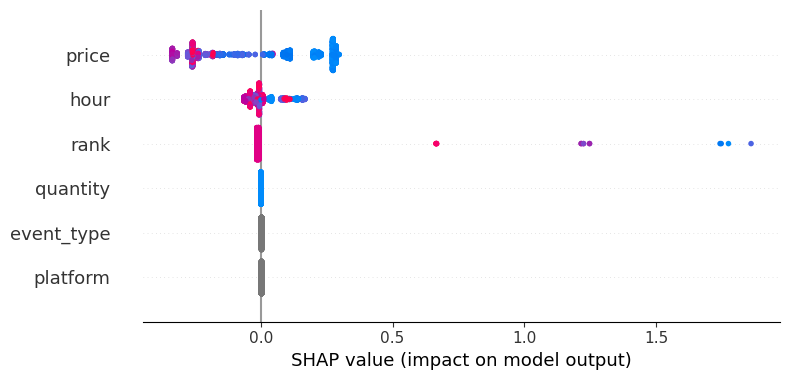

In [65]:
shap.summary_plot(shap_values, X_train, show = False, color_bar = False)

In [66]:
# predictions on test
y_test_pred = cbm_classifier.predict_proba(X_test)

In [67]:
from sklearn.metrics import roc_auc_score

print(f"ROC AUC score = {roc_auc_score(y_test, y_test_pred[:, 1]):.2f}")

ROC AUC score = 0.62


## 2.6. Evaluation on global test

In [68]:
global_test_predictions = pd.DataFrame({
    'user_id': global_test['user_id'].unique()
        }
    )

# only warm start
global_test_predictions = global_test_predictions.loc[global_test_predictions['user_id'].isin(local_train.user_id.unique())]

In [69]:
# set param for number of candidates
top_k = 100

# generate list of watched titles to filter
watched_movies = local_train.groupby('user_id')['item_id'].apply(list).to_dict()

mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids = all_cols, 
    known_items = watched_movies,
    N = top_k,
    user_features = None, 
    item_features = None, 
    user_mapping = lightfm_mapping['users_mapping'],
    item_inv_mapping = lightfm_mapping['items_inv_mapping'],
    num_threads = 10
)

global_test_predictions['item_id'] = global_test_predictions['user_id'].map(mapper)
global_test_predictions = global_test_predictions.explode('item_id').reset_index(drop=True)
global_test_predictions['rank'] = global_test_predictions.groupby('user_id').cumcount() + 1 

In [71]:
cbm_global_test = global_test_predictions.fillna(global_test_predictions.mode().iloc[0])

In [72]:
# make predictions
cbm_global_test['cbm_preds'] = cbm_classifier.predict_proba(cbm_global_test[X_train.columns])[:, 1]
cbm_global_test.head()

KeyError: "['platform', 'event_type', 'price', 'quantity', 'hour'] not in index"

In [ ]:
# set cbm rank
cbm_global_test = cbm_global_test.sort_values(by = ['user_id', 'cbm_preds'], ascending = [True, False])
cbm_global_test['cbm_rank'] = cbm_global_test.groupby('user_id').cumcount() + 1

In [ ]:
cbm_global_test.head()

Now, let's move on to comparison
- define function to calculate matrix-based metrics;
- create table of metrics for both models

In [73]:
def calc_metrics(df_true, df_pred, k: int = 10, target_col = 'rank'):
    """
    calculates confusion matrix based metrics
    :df_true: pd.DataFrame
    :df_pred: pd.DataFrame
    :k: int, 
    """
    # prepare dataset
    df = df_true.set_index(['user_id', 'item_id']).join(df_pred.set_index(['user_id', 'item_id']))
    df = df.sort_values(by = ['user_id', target_col])
    df['users_watch_count'] = df.groupby(level = 'user_id')[target_col].transform(np.size)
    df['cumulative_rank'] = df.groupby(level = 'user_id').cumcount() + 1
    df['cumulative_rank'] = df['cumulative_rank'] / df[target_col]
    
    # params to calculate metrics
    output = {}
    num_of_users = df.index.get_level_values('user_id').nunique()

    # calc metrics
    df[f'hit@{k}'] = df[target_col] <= k
    output[f'Precision@{k}'] = (df[f'hit@{k}'] / k).sum() / num_of_users
    output[f'Recall@{k}'] = (df[f'hit@{k}'] / df['users_watch_count']).sum() / num_of_users
    output[f'MAP@{k}'] = (df["cumulative_rank"] / df["users_watch_count"]).sum() / num_of_users
    print(f'Calculated metrics for top {k}')
    return output

In [74]:
# first-level only - LightFM
lfm_metrics = calc_metrics(global_test, global_test_predictions)
lfm_metrics

Calculated metrics for top 10


{'Precision@10': 7.600681889746684e-05,
 'Recall@10': 0.0003426390225176708,
 'MAP@10': 0.00011830163348017498}

In [ ]:
# LightFM + ReRanker
# full_pipeline_metrics = calc_metrics(global_test, cbm_global_test, target_col = 'cbm_rank')
# full_pipeline_metrics

In [77]:
# metrics_table = pd.concat(
#     [pd.DataFrame([lfm_metrics]),
#     pd.DataFrame([full_pipeline_metrics])],
#     ignore_index = True
# )
# metrics_table.index = ['LightFM', 'FullPipeline']

# # calc relative diff
# metrics_table = metrics_table.append(metrics_table.pct_change().iloc[-1].mul(100).rename('lift_by_ranker, %'))

# metrics_table